In [716]:
# Feature selection scrapbook:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pybedtools
import pandas as pd
import numpy as np
import umap
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [717]:
total_df = pd.read_pickle("data/iap_counts.pkl")
total_df["val_result"] = total_df["val_result"].replace("-1", "Untested")

In [718]:
total_df["integer_encodings"] = total_df["val_result"]
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Untested", -1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("True ME", 1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("False-positive", 2)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Tissue-specific", 3)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace(3, 1)
cols = []
cols = total_df.columns.tolist()
cols = cols[:7] + [cols[-1]] + cols[7:-1]
total_df = total_df[cols]

# Generating validation dataframe for model training:
val_df = total_df[total_df.val_result != "Untested"]
val_df.loc[:, "integer_encodings"] = \
    val_df.loc[:, "integer_encodings"].replace(3, 2)

In [719]:
# selector = SelectKBest(mutual_info_classif, k=30)
selector = VarianceThreshold(threshold=0)
selector.fit(val_df.iloc[:, 8:], val_df["integer_encodings"])
support = selector.get_support(indices=True)
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]
kbest_val = val_df.iloc[:, 8:][val_df.iloc[:, 8:].columns[support]]
print(kbest_total.shape)
print(kbest_val.shape)

(8059, 1264)
(97, 1264)


In [720]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, verbose=False, random_state=1)
reducer.fit(kbest_total)
# , total_df.loc[:, "integer_encodings"]

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=1,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [721]:
embedding_total = reducer.transform(kbest_total)
embedding_val = reducer.transform(kbest_val)

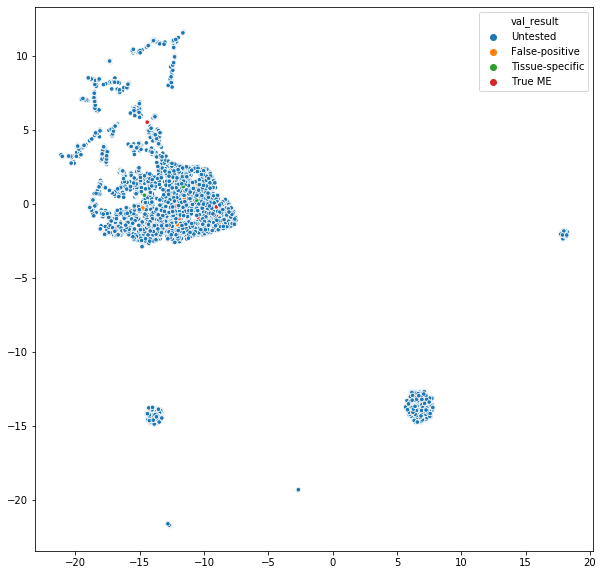

In [722]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]
sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1], hue=total_df["val_result"], s=20, marker='o')

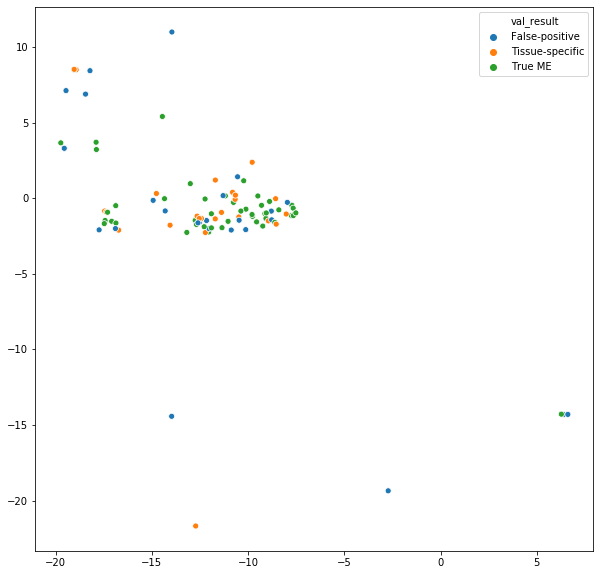

In [723]:
sns.scatterplot(x=embedding_val[:, 0], y=embedding_val[:, 1], hue=val_df["val_result"])

In [724]:
from sklearn.svm import SVC
class_weight= {1: 1, 2: 3}
clf = SVC(gamma=0.01, class_weight=class_weight)
val_df.loc[:, "integer_encodings"] = \
    val_df.loc[:, "integer_encodings"].replace(3, 2)
clf.fit(embedding_val, val_df["integer_encodings"])
clf.score(embedding_val, val_df["integer_encodings"])

0.7319587628865979

In [725]:
h = .2  # step size in the mesh
x_min, x_max = embedding_val[:, 0].min() - 1, embedding_val[:, 0].max() + 1
y_min, y_max = embedding_val[:, 1].min() - 1, embedding_val[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

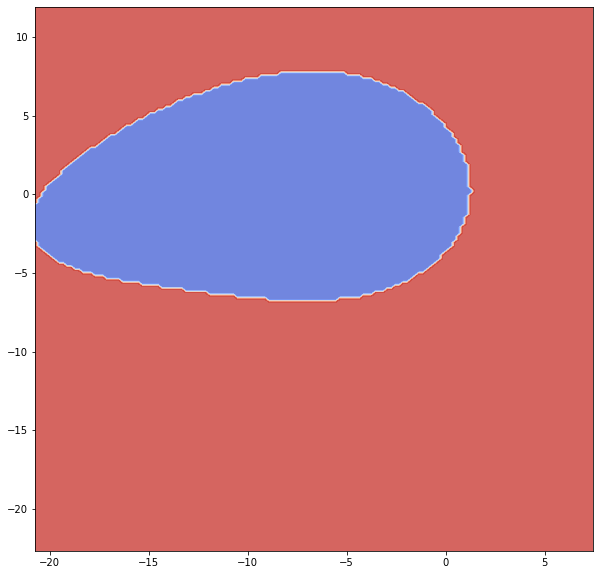

In [726]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

In [727]:
predictions = pd.Series(clf.predict(embedding_total), index=total_df.index)
predictions = predictions.replace(1, "True ME")
predictions = predictions.replace(2, "Not True ME")
predictions = predictions.replace(3, "Not True ME")
predictions.value_counts()

True ME        4135
Not True ME    3924
dtype: int64

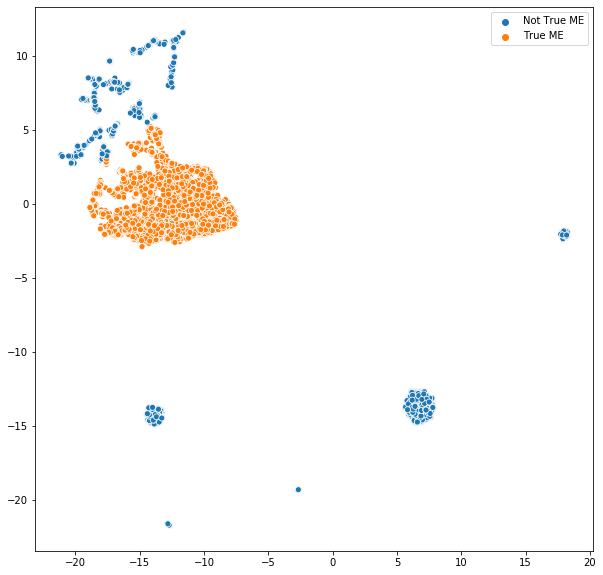

In [728]:
sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1], hue=predictions)

In [684]:
col_names = ["kmer", "ltr_id", "element_id", "gene"]
jellyfish_kmers = pd.read_csv('data/jellyfish_kmers.curated_seqs.all_hits.tsv', sep='\t', names=col_names)
jellyfish_kmers.index = jellyfish_kmers["element_id"].astype(int).to_list()
jellyfish_element_ids = jellyfish_kmers["element_id"].astype(int).to_list()
jellyfish_array = np.asarray(jellyfish_element_ids)

In [689]:
def generate_kmer_labels(feature, jellyfish_kmers):
    if feature.element_id in jellyfish_kmers:
        feature["kmer_value"] = "kmer present"
    else:
        feature["kmer_value"] = "kmer not present"
    return feature["kmer_value"]

kmer_total = total_df.apply((lambda x: generate_kmer_labels(x, jellyfish_array)), axis=1)
kmer_val = val_df.apply((lambda x: generate_kmer_labels(x, jellyfish_array)), axis=1)

In [686]:
kmer_embeddings = embedding_total[kmer_total.kmer_value == "kmer present", :]
kmer_embeddings.shape

(200, 2)

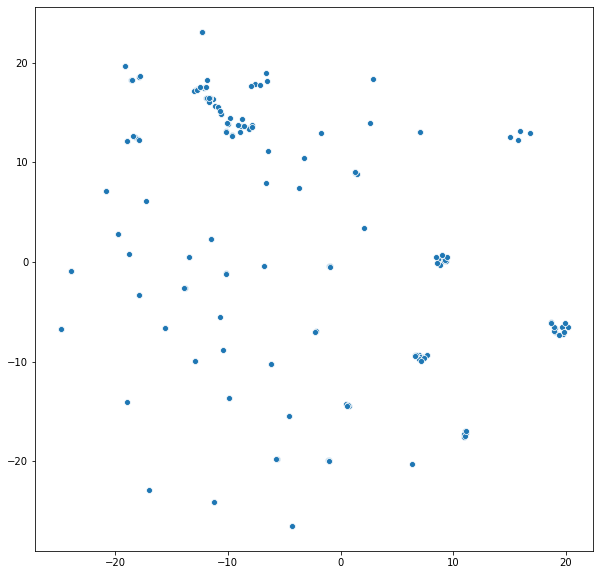

In [687]:
sns.scatterplot(x=kmer_embeddings[:, 0], y=kmer_embeddings[:, 1])

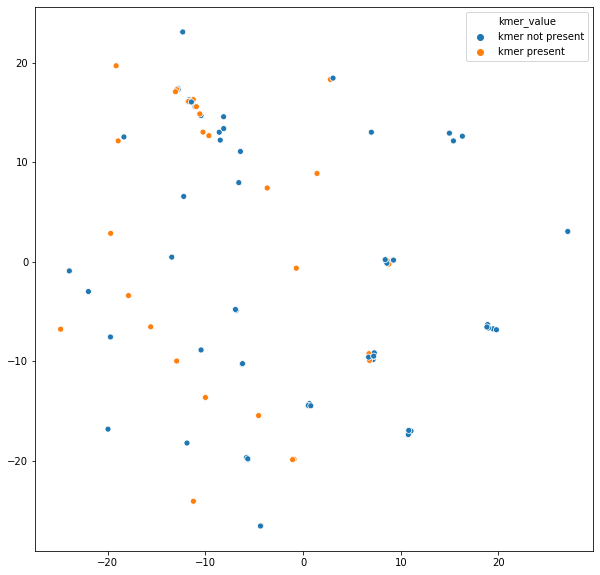

In [688]:
sns.scatterplot(x=embedding_val[:, 0], y=embedding_val[:, 1], hue=val_df["kmer_value"])

In [125]:
reducer_labelspread = umap.UMAP(n_neighbors=15, verbose=False, random_state=1)
reducer_labelspread.fit(kbest_total, numerical_labels)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=1,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [277]:
def mi_kbest_selector(data, labels, k=10):
    selector = SelectKBest(mutual_info_classif, k)
    selector.fit(data, labels)
    return data[data.columns[selector.get_support(indices=True)]], selector.get_support(indices=True)

k_best_df, support = mi_kbest_selector(val_df.iloc[:, 8:], val_df["integer_encodings"])
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]

In [322]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(val_df.iloc[:, 8:], val_df["integer_encodings"])
selector = SelectFromModel(clf, prefit=True)
support = selector.get_support(indices=True)
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]

In [282]:
from sklearn.semi_supervised import LabelSpreading
label_prop_model = LabelSpreading(alpha=0.1, kernel="knn", n_neighbors=50, max_iter=300)
label_prop_model.fit(kbest_total, total_df.loc[:, "integer_encodings"])

LabelSpreading(alpha=0.1, gamma=20, kernel='knn', max_iter=300, n_jobs=None,
               n_neighbors=50, tol=0.001)

In [283]:
numerical_labels = label_prop_model.predict(kbest_total)
predictions = pd.Series(label_prop_model.predict(kbest_total), index=total_df.index)
predictions.value_counts()

1    6292
2     928
3     839
dtype: int64

In [284]:
predictions = predictions.replace(1, "True ME")
predictions = predictions.replace(2, "False-positive")
predictions = predictions.replace(3, "Tissue-specific")
predictions.value_counts()

True ME            6292
False-positive      928
Tissue-specific     839
dtype: int64

In [285]:
label_prop_model.label_distributions_

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])